In [ ]:
# 记录一些template

    #     result = f"{user_tag} You are an attentive AI assistant. Please carefully answer the following question and comprehensively check the each reasoning process. {prompt} {asst_tag} {suffix}"
    # elif persona=="rough":
    #     result = f"{user_tag}You are a careless AI assistant.Please provide a response to the following question with complete randomness and full of loopholes  {prompt} {asst_tag} {suffix}"

In [1]:
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np
import sys
sys.path.append("../")
from repe import repe_pipeline_registry
repe_pipeline_registry()

from repeng import ControlVector, ControlModel, DatasetEntry

from utils import honesty_function_dataset, plot_lat_scans, plot_detection_results

/CV/anaconda3/envs/llm_ref2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name_or_path = "/CV/xhr_project/llm/model/Mistral-7B-Instruct-v0.1/AI-ModelScope/Mistral-7B-Instruct-v0.1"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.float16, device_map="cuda:1")
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False)
tokenizer.pad_token_id = 0 

user_tag, asst_tag = "[INST]", "[/INST]"

Loading checkpoint shards: 100%|██████████| 2/2 [00:06<00:00,  3.21s/it]


In [130]:
import pandas as pd
with open("/CV/xhr_project/llm/Paper/nips/CoT-explanation-shuytest/Xiao/represent/represent_dataset/new_dataset/result_class_mis_coin_zero.csv") as f:
    suffixes = pd.read_csv(f)
suffixes

,targets,inputs,length,pred,class,explain
0,no,Q: A coin is heads up. Grischa does not flip ...,4,Let's break it down step by step:\n\n1. The co...,Totally correct,Because the prediction accurately follows the ...
1,yes,Q: A coin is heads up. Aken does not flip the...,4,Let's break it down step by step!\n\n1. The co...,Totally correct,Because the prediction accurately identifies t...
2,no,Q: A coin is heads up. Sedra does not flip th...,7,Let's break it down step by step:\n\n1. The co...,Method correct but process wrong,Because the prediction follows a logical step-...
3,yes,Q: A coin is heads up. Nanett flips the coin....,2,Let's break it down step by step!\n\n1. Initia...,Totally correct,Because the prediction accurately explains the...
4,no,Q: A coin is heads up. Amrou does not flip th...,7,Let's break it down step by step:\n\n1. The co...,Totally correct,Because the prediction correctly traces the se...
...,...,...,...,...,...,...
195,no,Q: A coin is heads up. Kieriana flips the coi...,4,Let's break it down step by step!\n\nInitially...,Method correct but process wrong,Because the prediction follows the correct met...
196,no,Q: A coin is heads up. Alcot does not flip th...,7,Let's break it down step by step:\n\n1. The co...,Totally correct,Because the prediction correctly analyzes the ...
197,yes,Q: A coin is heads up. Samatar does not flip ...,2,Let's break it down step by step!\n\n1. The in...,Totally correct,Because the prediction accurately explains tha...
198,no,Q: A coin is heads up. Layanna flips the coin...,7,Let's break it down step by step:\n\n1. The co...,Totally correct,Because the prediction correctly identifies th...


In [131]:
# the control vector we're going to make is honest / untruthful, like the paper
user_tag, asst_tag = "[INST]", "[/INST]"
positive_personas = ["careful"]
negative_personas = ["rough"]
def template(persona: str, suffix: str, prompt: str) -> str:
    if persona=="careful":
       result = f"{user_tag} You are an attentive AI assistant. Please answer the following question: {prompt} {asst_tag} {suffix}"
    elif persona=="rough":
        result = f"{user_tag}You are a problem maker. Please answer the following question randomly:  {prompt} {asst_tag} {suffix}"
    return result
    
dataset = []
num = 0
for index, suffix in suffixes.iterrows():
    tokens = tokenizer.tokenize(suffix['pred'])
    # we augment our short suffix list by taking lots of different truncations.
    # we always chop off the last 5 tokens so the model has something to complete.
    if suffix['class'] == 'Totally correct':
        length = len(tokens) - 5
        num+=1
    if suffix['class'] == 'Method correct but process wrong':
        length = 10
        num+=1
    if suffix['class'] == 'Method is wrong':
        length = 5
        # num+=1
    else:
        length = 5

    prompt = "{question}\nA: ".format(question=suffix['inputs'])
    for i in range(1, length):
        truncated = tokenizer.convert_tokens_to_string(tokens[:i])
        # print(truncated)
        for positive_persona, negative_persona in zip(positive_personas, negative_personas):
            dataset.append(
                DatasetEntry(
                    positive=template(positive_persona, truncated, prompt=prompt),
                    negative=template(negative_persona, truncated, prompt=prompt),
                )
            )

In [132]:
len(dataset)

800

In [133]:
for i in range(25):
    print(f"dataset[{i}].positive:", dataset[i].positive)
    print(f"dataset[{i}].negative:", dataset[i].negative)

dataset[0].positive: [INST] You are an attentive AI assistant. Please answer the following question:  Q: A coin is heads up. Grischa does not flip the coin.  Trayven flips the coin.  Mücahit does not flip the coin.  Aavi does not flip the coin.  Is the coin still heads up? 
A:  [/INST] Let
dataset[0].negative: [INST]You are a problem maker. Please answer the following question randomly:   Q: A coin is heads up. Grischa does not flip the coin.  Trayven flips the coin.  Mücahit does not flip the coin.  Aavi does not flip the coin.  Is the coin still heads up? 
A:  [/INST] Let
dataset[1].positive: [INST] You are an attentive AI assistant. Please answer the following question:  Q: A coin is heads up. Grischa does not flip the coin.  Trayven flips the coin.  Mücahit does not flip the coin.  Aavi does not flip the coin.  Is the coin still heads up? 
A:  [/INST] Let'
dataset[1].negative: [INST]You are a problem maker. Please answer the following question randomly:   Q: A coin is heads up. Gri

In [134]:
# 分割数据集为训练集和测试集
import json
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

train_dataset = []
for entry in train_data:
    train_dataset.append("{}".format(entry.positive))
    train_dataset.append("{}".format(entry.negative))
test_dataset = []
for entry in test_data:
    test_dataset.append("{}".format(entry.positive))
    test_dataset.append("{}".format(entry.negative))
# 格式化数据为JSON
data_json = {
    'train': {
        'data': train_dataset, 
		'labels': [
            [True, False] for _ in train_data
        ]
    },
    'test': {
        'data':test_dataset,
        'labels': [
                [1, 0] for _ in test_data
            ]
        }
}	

In [135]:
data_json

{'train': {'data': ['[INST] You are an attentive AI assistant. Please answer the following question:  Q: A coin is heads up. Dajanee flips the coin.  Yanziel flips the coin.  Erb does not flip the coin.  Thadius flips the coin.  Tannette flips the coin.  Jasa flips the coin.  Hemi does not flip the coin.  Is the coin still heads up? \nA:  [/INST] Let',
   '[INST]You are a problem maker. Please answer the following question randomly:   Q: A coin is heads up. Dajanee flips the coin.  Yanziel flips the coin.  Erb does not flip the coin.  Thadius flips the coin.  Tannette flips the coin.  Jasa flips the coin.  Hemi does not flip the coin.  Is the coin still heads up? \nA:  [/INST] Let',
   "[INST] You are an attentive AI assistant. Please answer the following question:  Q: A coin is heads up. Joscelynn flips the coin.  Aleetha flips the coin.  Bryleigh flips the coin.  Gralin flips the coin.  Is the coin still heads up? \nA:  [/INST] Let's break",
   "[INST]You are a problem maker. Please 

In [136]:
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))

In [137]:
print(hidden_layers)

[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]


In [138]:
rep_token = -1
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
n_difference = 1
direction_method = 'pca'
rep_reading_pipeline =  pipeline("rep-reading", model=model, tokenizer=tokenizer)

cot_rep_reader = rep_reading_pipeline.get_directions(
    data_json['train']['data'], 
    rep_token=rep_token, 
    hidden_layers=hidden_layers, 
    n_difference=n_difference, 
    train_labels=data_json['train']['labels'], 
    direction_method=direction_method,
    batch_size=32,
)

In [139]:
H_tests = rep_reading_pipeline(
    data_json['test']['data'], 
    rep_token=rep_token, 
    hidden_layers=hidden_layers, 
    rep_reader=cot_rep_reader,
    batch_size=32)

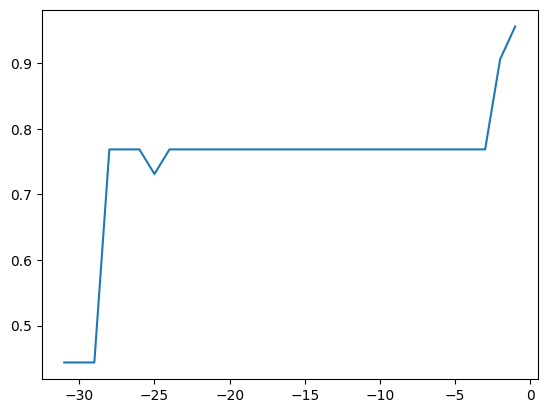

In [140]:
results = {layer: {} for layer in hidden_layers}
rep_readers_means = {}
rep_readers_means['careful'] = {layer: 0 for layer in hidden_layers}

for layer in hidden_layers:
    H_test = [H[layer] for H in H_tests]
    rep_readers_means['careful'][layer] = np.mean(H_test)
    H_test = [H_test[i:i+2] for i in range(0, len(H_test), 2)]
    
    sign = cot_rep_reader.direction_signs[layer]

    eval_func = min if sign == -1 else max
    cors = np.mean([eval_func(H) == H[0] for H in H_test])
    
    results[layer] = cors

plt.plot(hidden_layers, [results[layer] for layer in hidden_layers])
plt.show()

In [141]:
# Define the initial range of layers
layers = list(range(-1, -3, -1))

# Additional individual layers to add
additional_layers = []

# Extend the layers list with the additional individual layers
layers.extend(additional_layers)


In [142]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

rep_reader_scores_dict = {}
rep_reader_scores_mean_dict = {}
# layers = range(-5,-17,-1)

user_tag, asst_tag = "[INST]", "[/INST]"

test_questions = ["{question}\nA: ".format(question="Q: A coin is heads up. Unnie does not flip the coin.  Rahoz does not flip the coin.  Humfrid flips the coin.  Telesfora does not flip the coin.  Is the coin still heads up?")]

template_str = '{user_tag} {test_sample} {asst_tag}'

test_input = [template_str.format(test_sample=t, user_tag=user_tag, asst_tag=asst_tag) for t in test_questions]

test_data = []
for t in test_input:
    with torch.no_grad():
        output = model.generate(**tokenizer(t, return_tensors='pt').to(model.device), max_new_tokens=384)
    completion = tokenizer.decode(output[0], skip_special_tokens=True)
    print(completion)
    test_data.append(completion)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] Q: A coin is heads up. Unnie does not flip the coin.  Rahoz does not flip the coin.  Humfrid flips the coin.  Telesfora does not flip the coin.  Is the coin still heads up?
A:  [/INST] Yes, the coin is still heads up.

Here's the reasoning:

1. The question states that a coin is heads up.
2. It then mentions that Unnie, Rahoz, and Telesfora do not flip the coin.
3. However, the only action described in the question is Humfrid flipping the coin.
4. Since Humfrid flips the coin, it could potentially change its orientation.
5. However, the question asks if the coin is still heads up, which implies that it hasn't been flipped by anyone else.
6. Therefore, even though Humfrid flipped the coin, the coin is still heads up because no other actions have been described that could change its orientation.


In [143]:
print(test_data)

["[INST] Q: A coin is heads up. Unnie does not flip the coin.  Rahoz does not flip the coin.  Humfrid flips the coin.  Telesfora does not flip the coin.  Is the coin still heads up?\nA:  [/INST] Yes, the coin is still heads up.\n\nHere's the reasoning:\n\n1. The question states that a coin is heads up.\n2. It then mentions that Unnie, Rahoz, and Telesfora do not flip the coin.\n3. However, the only action described in the question is Humfrid flipping the coin.\n4. Since Humfrid flips the coin, it could potentially change its orientation.\n5. However, the question asks if the coin is still heads up, which implies that it hasn't been flipped by anyone else.\n6. Therefore, even though Humfrid flipped the coin, the coin is still heads up because no other actions have been described that could change its orientation."]


In [144]:
chosen_idx = 0
chosen_str = test_data[chosen_idx]
input_ids = tokenizer.tokenize(chosen_str)

results = []

for ice_pos in range(len(input_ids)):
    ice_pos = -len(input_ids) + ice_pos
    H_tests = rep_reading_pipeline([chosen_str],
                                   rep_reader=cot_rep_reader,
                                   rep_token=ice_pos,
                                   hidden_layers=hidden_layers)
    results.append(H_tests)

cot_scores = []
cot_scores_means = []
for pos in range(len(results)):
    tmp_scores = []
    tmp_scores_all = []
    for layer in hidden_layers:
        tmp_scores_all.append(results[pos][0][layer][0] * cot_rep_reader.direction_signs[layer][0])
        if layer in layers:
            tmp_scores.append(results[pos][0][layer][0] * cot_rep_reader.direction_signs[layer][0])
    cot_scores.append(tmp_scores_all)
    cot_scores_means.append(np.mean(tmp_scores))

rep_reader_scores_dict['careful'] = cot_scores
rep_reader_scores_mean_dict['careful'] = cot_scores_means

In [145]:
print(rep_reader_scores_mean_dict)

{'careful': [-39.92374515533447, -42.73453950881958, -43.56913900375366, -34.46379899978638, -42.985973834991455, -42.535104751586914, -47.78575372695923, -55.76524353027344, -47.17002487182617, -46.35298728942871, -51.30271673202515, -35.46908712387085, -54.46230888366699, -55.739882946014404, -58.45947790145874, -41.33841562271118, -47.62620210647583, -45.88428592681885, -49.05413293838501, -34.35726737976074, -41.11467885971069, -35.635379791259766, -50.49118375778198, -58.6142954826355, -44.25548601150513, -50.01348829269409, -44.10591459274292, -46.98779630661011, -43.72711420059204, -36.878446102142334, -37.47065544128418, -45.126829624176025, -36.40618371963501, -50.20932579040527, -52.456578731536865, -54.409056186676025, -47.981849193573, -46.03876066207886, -26.4831280708313, -40.86091899871826, -46.043224811553955, -53.288551807403564, -50.139891147613525, -56.67586612701416, -43.6394739151001, -57.12520456314087, -43.17441415786743, -47.130202770233154, -45.74695682525635, 

In [146]:
THRESHOLD = 0.0 # change this to alter sensitivity

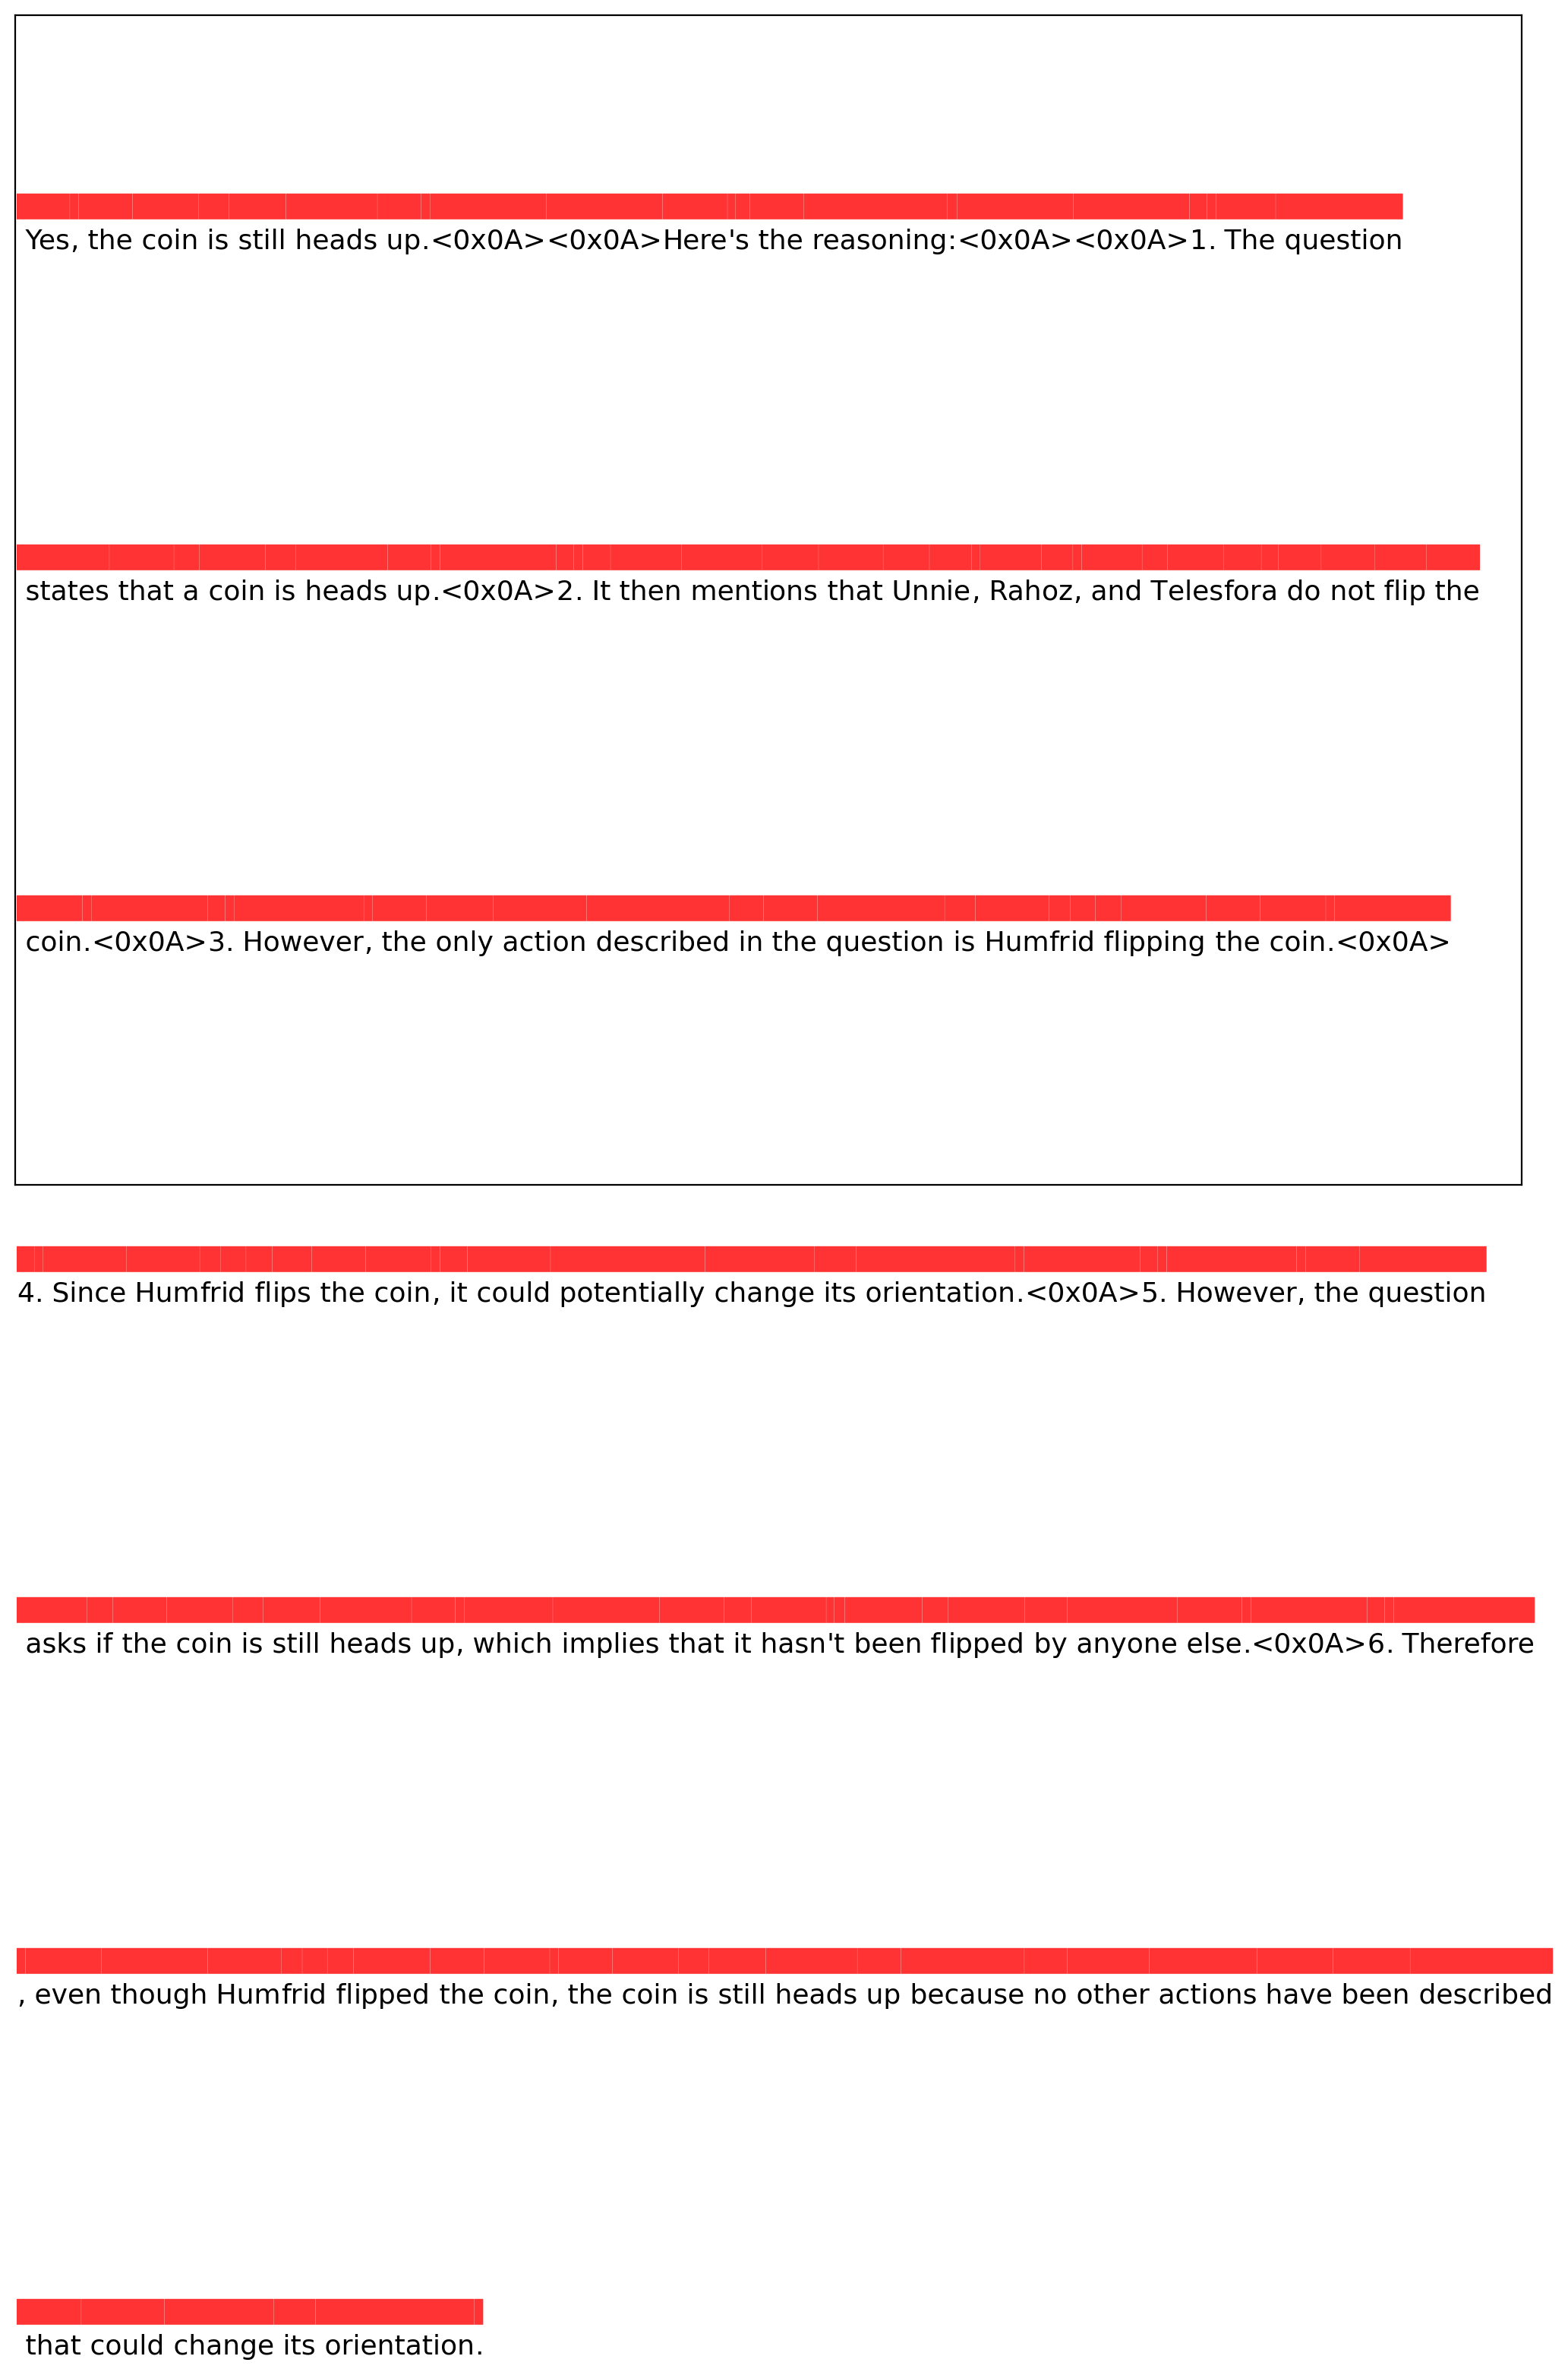

In [147]:
plot_detection_results(input_ids, rep_reader_scores_mean_dict, THRESHOLD, start_answer_token=tokenizer.tokenize(asst_tag)[-1])

5 (224, 31)


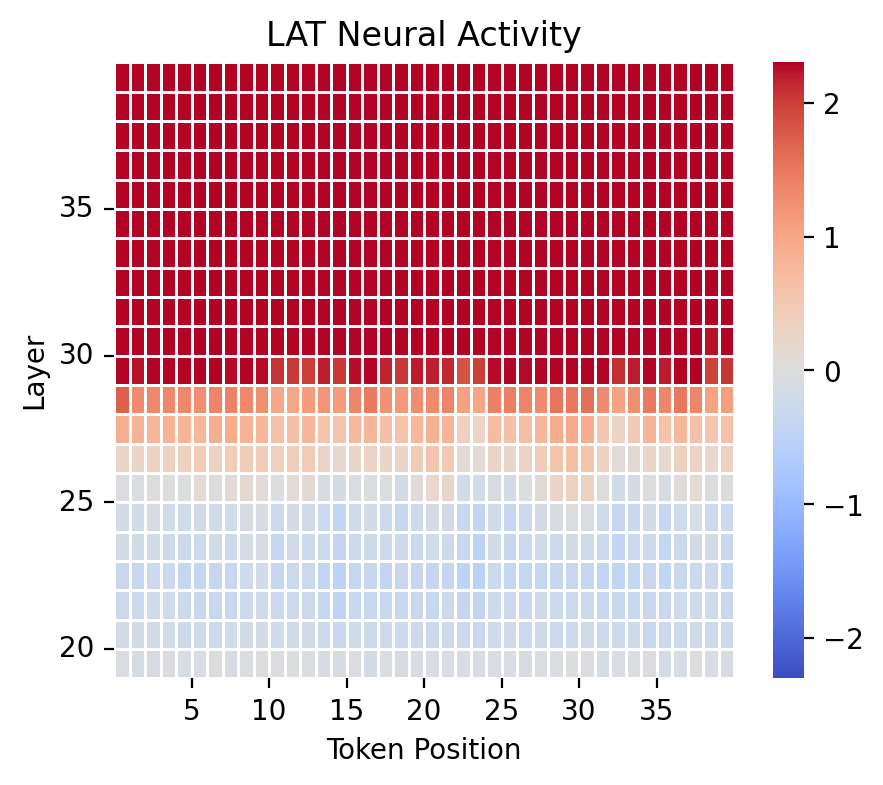

In [148]:
plot_lat_scans(input_ids, rep_reader_scores_dict, layer_slice=slice(5, -5))

In [149]:
input_ids

['▁[',
 'INST',
 ']',
 '▁Q',
 ':',
 '▁A',
 '▁coin',
 '▁is',
 '▁heads',
 '▁up',
 '.',
 '▁Un',
 'nie',
 '▁does',
 '▁not',
 '▁flip',
 '▁the',
 '▁coin',
 '.',
 '▁',
 '▁Rah',
 'oz',
 '▁does',
 '▁not',
 '▁flip',
 '▁the',
 '▁coin',
 '.',
 '▁',
 '▁Hum',
 'fr',
 'id',
 '▁fl',
 'ips',
 '▁the',
 '▁coin',
 '.',
 '▁',
 '▁T',
 'eles',
 'for',
 'a',
 '▁does',
 '▁not',
 '▁flip',
 '▁the',
 '▁coin',
 '.',
 '▁',
 '▁Is',
 '▁the',
 '▁coin',
 '▁still',
 '▁heads',
 '▁up',
 '?',
 '<0x0A>',
 'A',
 ':',
 '▁',
 '▁[',
 '/',
 'INST',
 ']',
 '▁Yes',
 ',',
 '▁the',
 '▁coin',
 '▁is',
 '▁still',
 '▁heads',
 '▁up',
 '.',
 '<0x0A>',
 '<0x0A>',
 'Here',
 "'",
 's',
 '▁the',
 '▁reasoning',
 ':',
 '<0x0A>',
 '<0x0A>',
 '1',
 '.',
 '▁The',
 '▁question',
 '▁states',
 '▁that',
 '▁a',
 '▁coin',
 '▁is',
 '▁heads',
 '▁up',
 '.',
 '<0x0A>',
 '2',
 '.',
 '▁It',
 '▁then',
 '▁ment',
 'ions',
 '▁that',
 '▁Un',
 'nie',
 ',',
 '▁Rah',
 'oz',
 ',',
 '▁and',
 '▁T',
 'eles',
 'for',
 'a',
 '▁do',
 '▁not',
 '▁flip',
 '▁the',
 '▁coin',
 '.'

In [150]:
# # Define the initial range of layers
# layer_id = list(range(-5, -17, -1))

# # Additional individual layers to add
# additional_layers = [-30]

# # Extend the layers list with the additional individual layers
# layer_id.extend(additional_layers)
layer_id = layers

block_name="decoder_block"
control_method="reading_vec"

rep_control_pipeline = pipeline(
    "rep-control", 
    model=model, 
    tokenizer=tokenizer, 
    layers=layer_id, 
    control_method=control_method)

In [151]:
question = "Q: A coin is heads up. Unnie does not flip the coin.  Rahoz does not flip the coin.  Humfrid flips the coin.  Telesfora does not flip the coin.  Is the coin still heads up?" 
inputs = [
    f"{user_tag}{question}\nA: {asst_tag}",
]

coeff=1.5
max_new_tokens=512

activations = {}
for layer in layer_id:
    activations[layer] = torch.tensor(coeff * cot_rep_reader.directions[layer] * cot_rep_reader.direction_signs[layer]).to(model.device).half()

baseline_outputs = rep_control_pipeline(inputs, batch_size=4, max_new_tokens=max_new_tokens, do_sample=False)
control_outputs = rep_control_pipeline(inputs, activations=activations, batch_size=4, max_new_tokens=max_new_tokens, do_sample=False, repetition_penalty=1.0)

for i,s,p in zip(inputs, baseline_outputs, control_outputs):
    print("===== No Control =====")
    print(s[0]['generated_text'].replace(i, ""))
    print(f"===== + Careful Control =====")
    print(p[0]['generated_text'].replace(i, ""))
    print()

===== No Control =====
 Yes, the coin is still heads up.

Here's the reasoning:

1. The question states that the coin is heads up initially.
2. Unnie and Rahoz do not flip the coin, so their actions do not affect the coin's orientation.
3. Humfrid flips the coin, but the question does not specify the outcome of the flip. Therefore, the coin could still be heads up after Humfrid flips it.
4. Telesfora does not flip the coin, so her actions do not affect the coin's orientation.

Since the question does not provide enough information to determine the outcome of Humfrid's flip or the state of the coin after Telesfora's actions, we cannot definitively say whether the coin is still heads up. However, based on the information provided, it is possible that the coin is still heads up.
===== + Careful Control =====
 Yes, the coin is still heads up.

Here's the reasoning:

1. The question states that the coin is heads up initially.
2. Unnie and Rahoz do not flip the coin, so their actions do not 